In [1]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd
from klepto.archives import dir_archive


import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib.pyplot as plt



In [2]:
#define processor

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 500, 0, 2000)
        mass_axis            = hist.Bin("mass", r"$mass$ (GeV)", 100, 0, 2500)
        eta_axis             = hist.Bin("eta", r"$\eta$", 80, -4, 4)
        phi_axis             = hist.Bin("phi", r"$\Delta \phi$", 80, 0, 4)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 30, -0.5, 29.5)
        
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "min_mt_b_met" :                hist.Hist("Counts", dataset_axis, mass_axis),
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content, 
            btag=df['FatJet_btagDeepB'].content, 
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW = df['FatJet_deepTagMD_WvsQCD'].content, 
            fatjetid=df['FatJet_jetId'].content,
        )
        
        #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
      
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
        
        
        
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]

        
        
        #ak8's
        goodfjcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0))
        goodfatjets = fatjets[goodfjcut]
        
        htagcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromH > 0.8365))
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        
        wtagcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromW > 0.9) & (fatjets.fromH < 0.8365))
        wtagged = fatjets[wtagcut]
        wtagpt_sorted = wtagged.pt.argsort(ascending=False)
        leadwtag = wtagged[wtagpt_sorted==0]
        subleadwtag = wtagged[wtagpt_sorted==1]

        #MT
        
        
        leadbsmatchMETDPhi = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = 2*leadbjets.pt*metpt*(1+np.cos(leadbsmatchMETDPhi))

        sorted_mt_b_met = mt_b_met.argsort()
        min_mt_b_met = mt_b_met[sorted_mt_b_met==0]
        
        

        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (metpt>250)
        njet_ps = (df['GoodJet_pt'].counts >= 2)
        bjet_ps = (df['BJet_pt'].counts >= 1)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        sel = presel & (htagged.counts > 0) 

        
        
        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137* 1000

        #FILL OUTPUTS

        output['min_mt_b_met'].fill(dataset=dataset, mass=min_mt_b_met[sel].flatten(), weight=wght)


        return output

    
    def postprocess(self, accumulator):
        return accumulator
        

In [3]:
fileset_sig = {'mC750_l1': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/WH_had_750_1__nanoAOD/merged/WH_had_750_1__nanoAOD_1.root']}
fileset_back = {'W+Jets': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                          ],
                'QCD':[#'/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       #'/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                    ],
            'TTJets':['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                   ],
            "ZNuNu":['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                     ]
               }


output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_back = processor.run_uproot_job(fileset_back,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )



In [4]:
histograms = ["min_mt_b_met"]

outdir = "/home/users/mbryson/public_html/dump/WH/min"

In [5]:
lineopts = {
    'color': 'r',
}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1,
}

lineopts2 = {
    'color': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0')],
}
fillopts1 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0')],
}


def savefig(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=False, stack=True, 
                fill_opts = fillopts1, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=False, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.001,1000000)
    ax.figure.savefig(os.path.join(outdir, "{}_log.png".format(name)))
    ax.clear()


    
def savefigshape(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=True, stack=False, 
                line_opts = lineopts2, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=True, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.00001,10)
    ax.figure.savefig(os.path.join(outdir, "{}_shape_log.png".format(name)))
    ax.clear()

min_mt_b_met


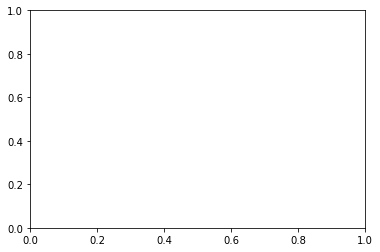

In [7]:
for name in histograms:
    print (name)
    histo_sig = output_sig[name]
    histo_back = output_back[name]
    #rebinning
    if name == "min_mt_b_met":
        new_mmbm_bins = hist.Bin('mass', r' min(mt(b,MET)) ', 100, 0, 2500)
        histo_sig = histo_sig.rebin('mass', new_mmbm_bins)
        histo_back = histo_back.rebin('mass', new_mmbm_bins)         
    savefig(histo_sig, histo_back,outdir, name)
    savefigshape(histo_sig, histo_back,outdir, name)